# 1 - Préparation du traitement des données

In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

t = time.time()

In [ ]:
NB_DATA_140 = 50000

Nous avons enregistré plusieurs versions des deux bases de données préprocessées (Sentiment140, base de tweets webscrapés) de manières différentes avec des combinaisons différentes des arguments *stop_words*, *lemmatization* et *negation*. Nous créons ici une fonction *data* qui, en fonction des paramètres de *preprocessing* choisis par l'utilisateur, chargera les deux *Dataframes* (sentiment140 et tweets scrapés) correspondants.

In [ ]:
def data(stop_words, lemmatization, negation):
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    df_140 = pd.read_pickle(os.path.join("data", "Sentiment140", file + ".bz2")).sample(NB_DATA_140, random_state=1234).reset_index(drop=True)

    file = "web"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    df_web = pd.read_csv(os.path.join("data", "webcsv", file + ".csv"))

    X_140 = df_140.text.to_list()
    y_140 = df_140.sentiment.to_list()

    X_web = df_web.Text.to_list()
    
    return X_140, y_140, X_web, df_web

Les études réalisées sur les modèles *Gaussian Naive Bayes*, *Multinomial Naive Bayes*, et *Logistic Regression*, nous ont permis de conclure que le modèle *Logistic Regression* couplé à la méthode de *feature extraction* *TfidfVectorizer avec ngram* donnait les meilleurs résultats. De plus, les études menées nous ont permis de conclure que la combinaison de paramètres de preprocessing la plus pertinente est la suivante : *stop_words=False*, *lemmatization=True*, *negation=False*.

Nous utiliserons donc les outils suivants pour traiter notre base webscrapée :

- modèle : LogisticRegression(max_iter=1000000, random_state=1234)
- vectorizer : TfidfVectorizer(max_features=2725, ngram_range=(1, 2))
- combinaison : stop_words=False, lemmatization=True, negation=False

In [ ]:
model = make_pipeline(TfidfVectorizer(max_features=2725, ngram_range=(1,2)), LogisticRegression(max_iter=1000000, random_state=1234))

# 2 - Application du modèle

Nous choisissons nos arguments de *preprocessing*, et nous appelons les bases correspondantes à l’aide de la fonction *data*.

In [ ]:
STOP_WORDS = False
LEMMATIZATION = True
NEGATION = False
X_140, y_140, X_web, df_web = data(STOP_WORDS, LEMMATIZATION, NEGATION)

On entraîne le modèle sur l'échantillon de la base Sentiment140 préprocessée selon la combinaison (*stop_words*, *lemmatization*, *negation*) choisie. 

In [ ]:
model.fit(X_140, y_140)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=2725, ngram_range=(1, 2))),
                ('logisticregression',
                 LogisticRegression(max_iter=1000000, random_state=1234))])

Une fois le modèle entraîné, il ne nous reste plus qu'à l'appliquer à notre base de tweets webscrapés. Ces tweets sont des commentaires faits par des utilisateurs de Tweeter à propos des films Dune et Space Jam.

L'idée de cette étude est devoir si l'un des deux films a connu plus de succès que l'autre, en identifiant le succès d'un film à la proportion de commentaires positifs qu'il a suscités chez les utilisateurs de Tweeter.

A priori, nous nous attendons à trouver que le film Dune a connu plus de succès que le film Space Jam. En particulier, nous nous attendons à trouver que Dune a connu un franc succès, alors que Space Jam a plutôt déçu.

In [ ]:
y_web = model.predict(X_web)

Une fois la prédiction effectuée par le modèle, il convient de l'ajouter au *DataFrame* sur lequel nous travaillons.

In [ ]:
df_web['sentiment'] = y_web

In [ ]:
df_web['sentiment'] = df_web['sentiment'].replace([0, 4], ["Négatif", "Positif"])

# 3 - Visualisation

Lors de la phase de *scraping* des données, des tweets ont été récoltés pour les deux films, à des moments stratégiques : 

- pendant deux semaines après la sortie du premier trailer
- pendant deux semaines après la sortie du deuxième trailer 
- pendant les deux semaines précédant la sortie du film, puis pendant les trois semaines suivant sa sortie en salle aux Etats-Unis 

[Text(0.5, 1.0, 'Sentiments exprimés (total)')]

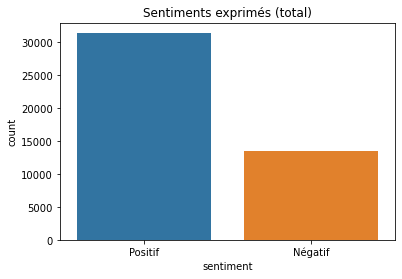

In [ ]:
sns.countplot(x='sentiment', data=df_web).set(title='Sentiments exprimés (total)')

Ce premier graphique montre que la base de tweets webscrapés contient une majorité de tweets positifs concernant les deux films étudiés. Cela laisse donc penser que dans l'ensemble, ces deux films étaient attendus sur la base d'a priori plutôt positifs, et qu'ils ont été plutôt appréciés par les personnes qui les ont vus.

[Text(0.5, 1.0, 'Sentiments exprimés concernant chaque film')]

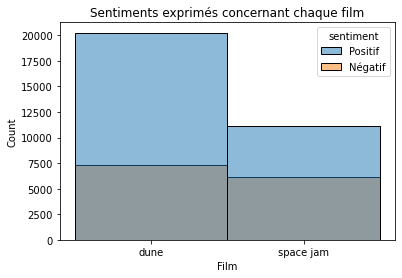

In [ ]:
sns.histplot(x='Film', hue='sentiment', data=df_web).set(title="Sentiments exprimés concernant chaque film")

Cet histogramme montre la répartition des sentiments pour les deux films. 

Attention: la foncttion histplot ne stacke pas les résultats mais les superpose horizontalement. Ainsi, dans le graphique ci-dessus, les tweets négatifs sont indiqués en orange dans la légende mais apparaissent gris sur le graphique car la barre orange qui est derrière se superpose au bleu. On doit donc lire le graphique en considérant que si la barre positif est au-dessus de la barre négatif c'est-qu'il y a plus de positif que de négatif.


Tout d'abord, il apparaît que Dune a beaucoup plus fait parler que Space Jam. De plus, Dune a suscité une majorité de commentaires positifs de la part des personnes qui ont tweeté à son propos, Space Jam a également reçu une majorité de commentaires positifs (la barre orange arrive au-dessus de la barre bleue) mais avec un ratio moins favorable que Dune.


Pour plus de lisibilité, nous remplaçons les dates des périodes pendant lesquelles les tweets scrapés ont été émis, par leur correspondance en termes de sortie d'un trailer ou de sortie d'un film.

In [ ]:
df_web = df_web.replace(["['2021-10-08', '2021-10-09', '2021-10-10', '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-16', '2021-10-17', '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-23', '2021-10-24', '2021-10-25', '2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13']",
                                                     "['2021-07-03', '2021-07-04', '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18', '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08']",
                                                     "['2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23']",
                                                     "['2021-07-22', '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26', '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05']",
                                                    "['2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17']",
                                                    "['2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23']"],
                                                    ["Sortie Dune", "Sortie Space Jam", "Premier trailer Dune", "Second trailer Dune","Premier trailer Space Jam", "Second trailer Space Jam"])


A présent, nous allons nous intéresser à la perception qu'avaient les personnes qui ont tweeté sur ces films, aux différents moments de la sortie des films (du premier trailer à la sortie en salle).

[Text(0.5, 1.0, 'Évolution des sentiments exprimés sur le film Dune à chaque période')]

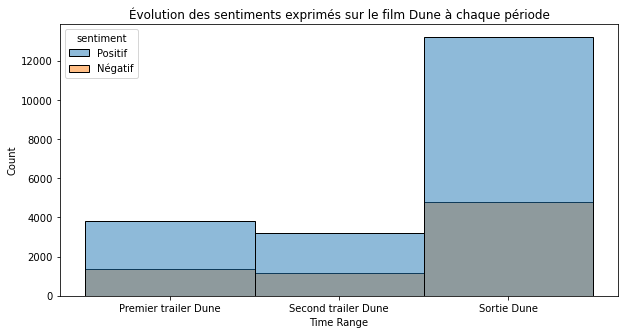

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(x='Time Range', hue='sentiment', data=df_web.loc[df_web['Film'] == 'dune']).set(title="Évolution des sentiments exprimés sur le film Dune à chaque période")

Tout d'abord, il apparaît que peu importe la période étudiée, Dune a suscité une majorité de tweets positifs.

Cet histogramme montre que le film était positivement attendu par les utilisateurs de Tweeter qui se sont exprimé à ce propos. Il montre également que le second trailer a suscité moins de réactions que le premier. Enfin, il apparaît que la sortie du film en salle a énormément fait parler, avec une grande majorité de tweets positifs.

[Text(0.5, 1.0, 'Évolution des sentiments exprimés sur le film Space Jam 2 à chaque période')]

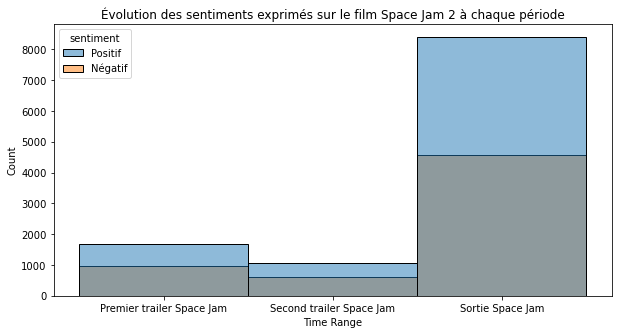

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(x='Time Range', hue='sentiment', data=df_web.loc[df_web['Film'] == 'space jam']).set(title="Évolution des sentiments exprimés sur le film Space Jam 2 à chaque période")

Les tendances sont assez similaires pour Space Jam, bien qu'elles soient beaucoup moins élogieuses que pour Dune. Par rapport à Dune, Space Jam a globalement suscité moins de réactions. 

La tendance principale qui se dégage est la suivante : peu importe la période étudiée, Space Jam a suscité une majorité de tweets positifs mais avec à chaque fois une proportion de tweets positifs sur le total de tweets publiés moins élevée que pour Dune.

Ainsi, les utilisateurs de Tweeter qui se sont exprimé à propos de Space Jam avaient, en majorité, un a priori positif sur le film mais moins que ceux qui s'exprimaient à propos de Dune. Comme pour Dune, la sortie du deuxième trailer a suscité moins de réactions que la sortie du premier trailer, même si elle a tout de même confirmé l'a priori positif moins marqué que pour Dune. Un à priori qui était suggéré par les tweets relatifs à la sortie du premier trailer. 

Enfin, il apparaît que la sortie du film en salle a suscité beaucoup plus de réactions que les trailers, avec toujours une majorité de tweets positifs.

Nos a priori semblent donc se confirmer : Dune semble avoir connu un franc succès, tandis que Space Jam a moins plu (même si la proportion de tweets positifs est supérieure à 1/2.

En vue d'améliorer la lisibilité des graphiques suivants, nous faisons en sorte de ne récupérer que le jour et le mois de la date de publication des tweets de notre base.

In [ ]:
df_web['day'] = df_web['Datetime'].apply(np.vectorize(lambda string : string[5:10]))

[Text(0.5, 1.0, 'Évolution des sentiments exprimés sur le film Dune')]

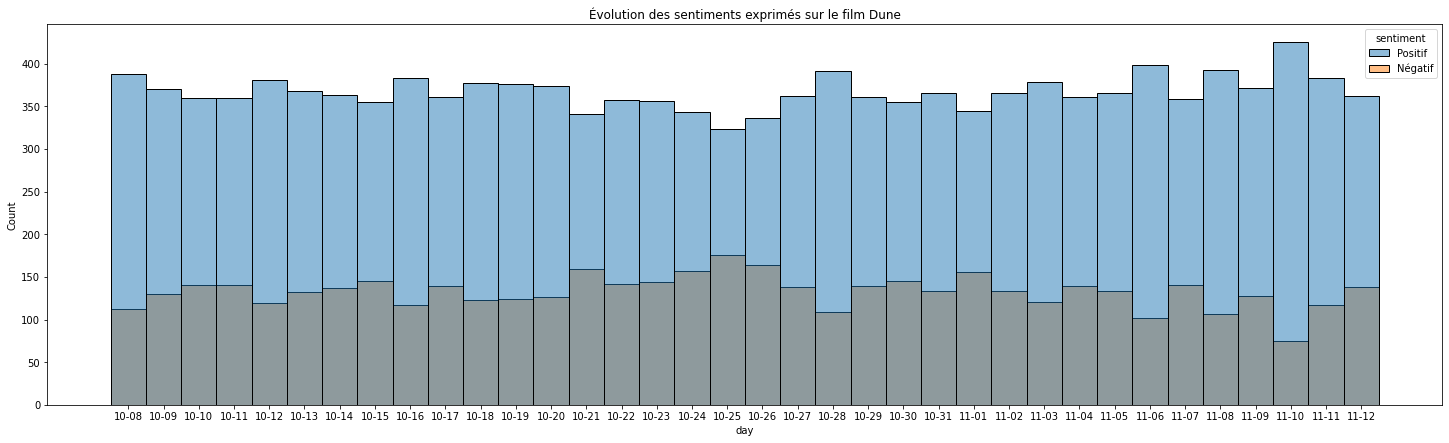

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(25, 7))
sns.histplot(x='day', hue='sentiment', data=df_web.loc[df_web['Film'] == 'dune'].loc[df_web['Time Range'] == "Sortie Dune"]).set(title="Évolution des sentiments exprimés sur le film Dune")

Ce graphique montre la répartition jour par jour des sentiments relatifs à Dune, les deux semaines précédant sa sortie en salle, et les trois semaines suivant cette dernière.

Notons d'abord que ce graphique ne stacke pas les résultats, ne les empile pas verticalement, mais les superpose horizontalement. Autrement dit, ce qui pourrait sembler être une variation quotidienne du nombre de tweets publiés à propos du film est un trompe-l'oeil. En réalité, pour obtenir le nombre de tweets publiés il faut additionner la hauteur des deux barres. Ce que révèlerait cette addition du nombre de tweets positifs (un peu moins de 400 le 10-08) et du nombre de tweets négatifs (un peu plus de 100 le 10-08) c'est que le nombre de tweets publiés chaque jour est constant: il s'agit d'un effet du scraping puisque l'on s'est limité à scraper 500 tweeets par jour. Ainsi, les données que nous avons récoltées permettent juste de savoir que, chaque jour, au moins 500 tweets ont été publiés sur Dune mais ne permettent pas de formuler d'observation sur l'évolution du nombre de tweets publiés dans le temps car le nombre de tweets scrapés chaque jour est constant.

Comme précédemment, il apparaît que dans l'immense majorité des cas, Dune a suscité chaque jour une majorité de commentaires positifs.

Pour observer une diminution franche du nombre de tweets publiés faisant référence à Dune, il aurait sans doute fallu étendre la période d'observation de quelques semaines.

[Text(0.5, 1.0, 'Évolution des sentiments exprimés sur le film Space Jam')]

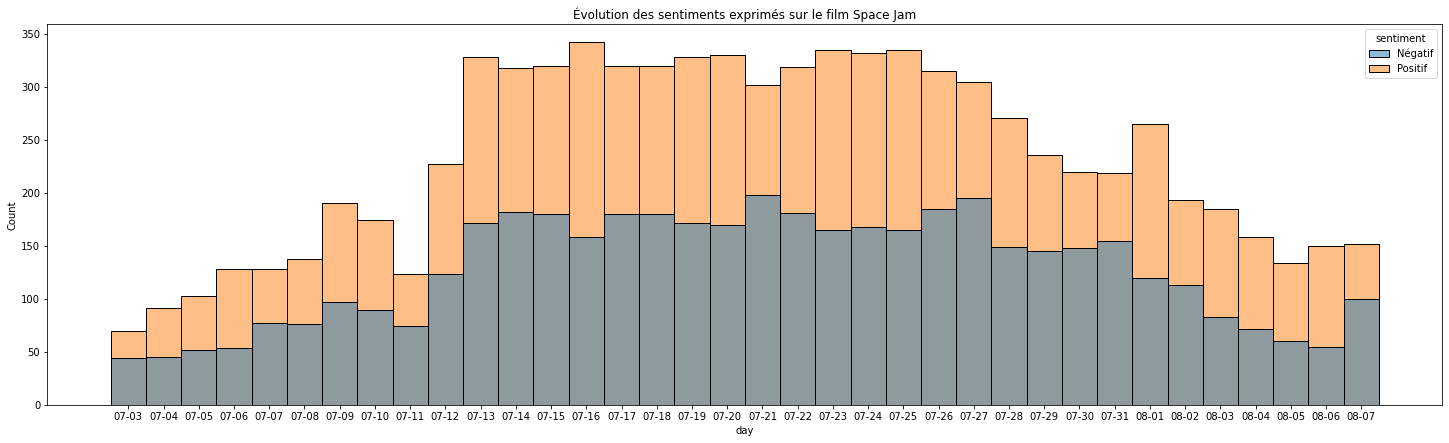

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(25, 7))
sns.histplot(x='day', hue='sentiment', data=df_web.loc[df_web['Film'] == 'space jam'].loc[df_web['Time Range'] == "Sortie Space Jam"]).set(title="Évolution des sentiments exprimés sur le film Space Jam")

Ce graphique montre la répartition jour par jour des sentiments relatifs à Space Jam, les deux semaines précédant sa sortie en salle, et les trois semaines suivant cette dernière.

Il apparaît que globalement, Space Jam a suscité des réactions plus mitigées  que Dune, malgré une majorité de commentaires positifs chaque jour (ou presque) (cela se voit au fait que la barre des sentiments positifs est plus haute que celle des sentiments négatifs car elle la dépasse par l'arrière). 

Contrairement à Dune, le nombre de tweets publiés chaque jour n'est pas du tout constant : il est très faible les premiers jours de la semaine qui précède la sortie du film en salle; il augmente jusqu'à la sortie du film, puis atteint le maximum scrapable de 500 tweeets par jour le 13 juillet c'est-à-dire trois jours avant la sortie du film. Ensuite, pendant deux semaines la capacité de scraping est saturée avec au moins 500 tweets par jour avant de retomber assez franchement les jours suivants (tendance qui n'est pas observée dans le cas de Dune).

Ces résultats soulignent le fait que Space Jam était un film bien moins attendu que Dune, et qui a beaucoup moins fait parler de lui après sa sortie.

## Conclusion

Toutes ces analyses nous ont permis de dégager plusieurs tendances, qui tendent à opposer Dune et Space Jam :

- Dune a suscité davantage de réactions positives que Space Jam
- Dune a suscité beaucoup plus de réactions que Space Jam
- Dune était un film plus attendu que Space Jam
- Dune est un film qui a fait beaucoup parler de lui pendant longtemps, contrairement a Space Jam dont la popularité est rapidement retombée après sa sortie

Finalement, tous ces résultats viennent confirmer nos a priori : Dune est un film qui a connu un franc succès, alors que Space Jam a globalement déçu.

On peut toutefois remarquer un fait, qui sans être une surprise, est très intéressant: la proportion de tweets positifs ou négatifs parmis ceux publiés à propos d'un film semble ne pas être impactée par la sortie du film. En particulier, pour Dune on ne voit pas d'évolution majeure entre les deux semaines précédant la sortie du Film et les trois suivantes et il en va, à peu de choses près, de même pour Space Jam.

Faut-il en conclure que les avis à propos d'un film sont déjà forgés avant sa sortie en salles ? On ne peut évidemment pas l'affirmer sur la base des données dont nous disposons mais il s'agit là d'un sujet qui mériterait une étude, ou un futur projet Python.

In [ ]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:00:25
